In [ ]:
print("hw")

%load_ext autoreload
%autoreload 2

In [10]:
from ocpaper231.data import get_dm


from ocpaper231.names import variable_manager
from pytorch_lightning import Trainer

from gnn_tracking.models.graph_construction import MLGraphConstruction

from ocpaper231.data import model_exchange_path
from gnn_tracking.graph_construction.k_scanner import GraphConstructionKNNScanner
from gnn_tracking.training.ml import MLModule
import pandas as pd
from matplotlib import pyplot as plt
import scienceplots
from ocpaper231.plotutils import Plot
from sklearn.manifold import TSNE


plt.style.use(["science", "notebook"])

In [2]:
chkpt_path = model_exchange_path / "gc" / "eggplant-quail-of-tempest.ckpt"
lmodel = MLModule.load_from_checkpoint(chkpt_path, map_location="cpu")
lmodel.gc_scanner = GraphConstructionKNNScanner(ks=list(range(1, 10)))

[18:38:48] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[18:38:48] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses
[18:38:48] DEBUG: Getting class GraphConstructionKNNScanner from module gnn_tracking.graph_construction.k_scanner


In [3]:
gc = MLGraphConstruction(
    ml=lmodel.model,
    max_num_neighbors=5,
)

In [4]:
dm = get_dm()
trainer = Trainer()
_ = trainer.validate(model=lmodel, datamodule=dm, verbose=False)

[18:38:48] INFO: DataLoader will load 900 graphs (out of 900 available).
[18:38:48] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_1/data21999_s0.pt
[18:38:48] INFO: DataLoader will load 5 graphs (out of 1000 available).
[18:38:48] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9/data29004_s0.pt
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  ra

Validation: 0it [00:00, ?it/s]

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


## FOMs vs k

In [11]:
class GCEffsVsKPlot(Plot):
    FILENAME = "gc_vs_k"

    def __init__(self, df: pd.DataFrame, **kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.ax.set_xlabel("$k$")

    def add_var(self, v: str):
        self.ax.plot("k", v, data=self.df, label=variable_manager[v].latex, marker="o")

    def plot(self):
        for v in ["frac50", "frac75", "frac100", "efficiency", "purity"]:
            self.add_var(v)
        self.ax.legend()

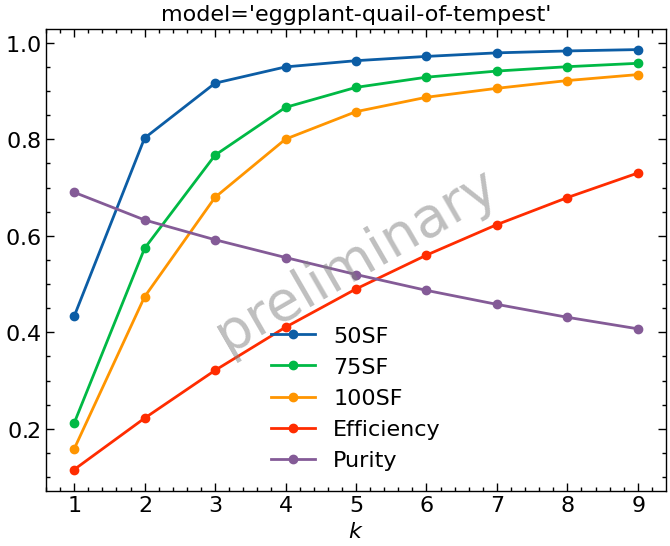

In [13]:
gce = GCEffsVsKPlot(
    lmodel.gc_scanner.get_results().df,
    model=chkpt_path.stem,
    watermark="preliminary",
    ax=None,
)
gce.plot()

## Edges vs k

In [14]:
class GCNEdgesVsKPlot(Plot):
    def __init__(self, df: pd.DataFrame, **kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.ax.set_xlabel("$k$")
        self.ax.set_ylabel("Number of edges")

    def plot(self):
        self.ax.plot("k", "n_edges", data=self.df, marker="o")

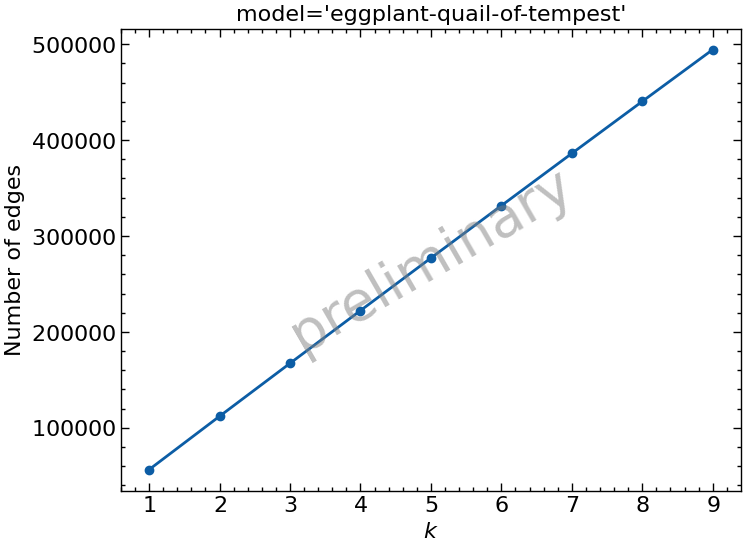

In [16]:
gcne = GCNEdgesVsKPlot(
    lmodel.gc_scanner.get_results().df,
    model=chkpt_path.stem,
    watermark="preliminary",
    ax=None,
)
gcne.plot()

## TSNE

In [0]:
data = dm.datasets["val"][0]
latent = lmodel.model(data)["H"]

In [76]:
x_tsne = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3, n_jobs=6
).fit_transform(data.x)
latent_tsne = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=3, n_jobs=6
).fit_transform(latent)

In [79]:
import torch
import numpy as np

selected_pids = torch.Tensor(
    np.random.choice(data.particle_id[data.pt > 0.9], 7).astype("int64")
)

In [93]:
from gnn_tracking.analysis.latent import get_color_mapper


class SimpleLatentSpacePlot(Plot):
    def __init__(self, latent_space, particle_id, selected_pids, *, ax=None, **kwargs):
        if ax is None:
            _, ax = plt.subplots(subplot_kw=dict(box_aspect=1))
        super().__init__(ax=ax, **kwargs)
        self.latent_space = latent_space
        self._particle_id = particle_id
        self._color_mapper = get_color_mapper(selected_pids)
        self._selected_pid_mask = torch.isin(particle_id, selected_pids)
        self.ax.set_xlabel("TSNE Dimension 1 [arbitrary units]")
        self.ax.set_ylabel("TSNE Dimension 2 [arbitrary units]")

    def plot(self):
        self.ax.scatter(
            self.latent_space[~self._selected_pid_mask, 0],
            self.latent_space[~self._selected_pid_mask, 1],
            c="k",
            s=0.5,
            alpha=0.3,
        )
        self.ax.scatter(
            self.latent_space[self._selected_pid_mask, 0],
            self.latent_space[self._selected_pid_mask, 1],
            c=self._color_mapper(self._particle_id[self._selected_pid_mask]),
        )

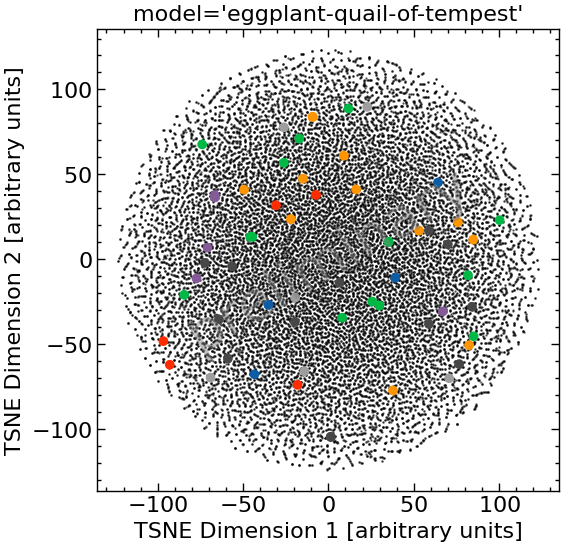

In [94]:
slsp = SimpleLatentSpacePlot(
    x_tsne,
    data.particle_id,
    selected_pids,
    ax=None,
    model=chkpt_path.stem,
    watermark="preliminary",
)
slsp.plot()

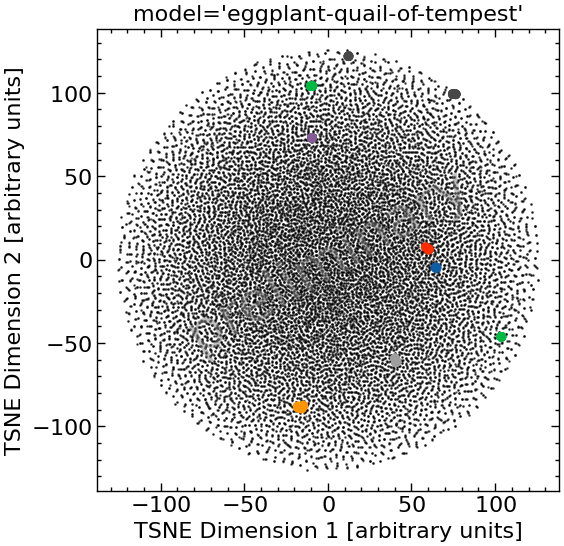

In [95]:
slsp = SimpleLatentSpacePlot(
    latent_tsne,
    data.particle_id,
    selected_pids,
    ax=None,
    model=chkpt_path.stem,
    watermark="preliminary",
)
slsp.plot()

(-20.0, 20.0)

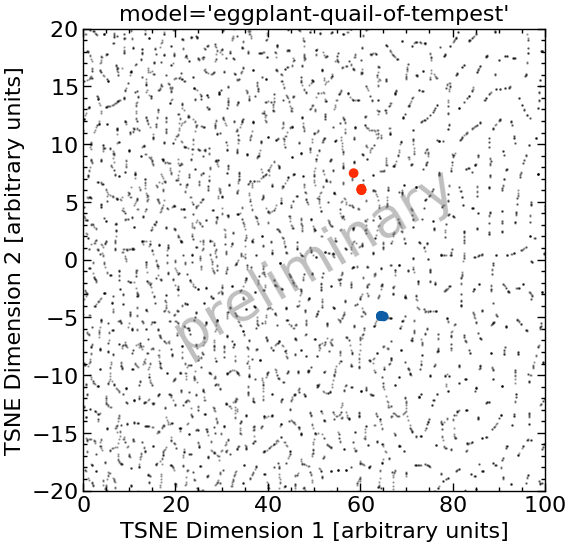

In [101]:
slsp = SimpleLatentSpacePlot(
    latent_tsne,
    data.particle_id,
    selected_pids,
    ax=None,
    model=chkpt_path.stem,
    watermark="preliminary",
)
slsp.plot()
slsp.ax.set_xlim(0, 100)
slsp.ax.set_ylim(-20, 20)